# Content
* [1. Data Preparation](#preparation)
* [2. Data Analysis](#analysis)

<a id='preparation'></a>
# 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb # Python debugger
from IPython.display import Image, display
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split, GridSearchCV
from tensorflow.keras import models, layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.regularizers import l2

In [2]:
data_dir = '../data/titanic/'

train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_data = pd.read_csv(os.path.join(data_dir, 'test.csv'))
df_data = train_data.append(test_data).reset_index(drop=True)
num_train = len(train_data)
print(f'# of training samples: {num_train}')
print(f'# of test samples: {len(test_data)}')

df_data_raw = df_data.copy() # We can use this to restore the mistakes we make in df_data

# of training samples: 891
# of test samples: 418


In [3]:
df_data.head(-1)
# df_data.iloc[0]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
display(train_data.head(), test_data.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print('Training null values\n')
print(train_data.isnull().sum()) # to know if there's missing value in the data
print('-'*30)
print('Testing null values\n')
print(test_data.isnull().sum())

Training null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------------------
Testing null values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
train_data.describe(include='all')
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Dataset Exploratory
- PassengerId
- Survived
- Pclass (Ticket class, 1, 2, 3)
- Name
- Sex (male, female)
- Age
- SibSp (# of siblings / spouses aboard the Titanic, 0~8)
- Parch (# of parents / children aboard the Titanic, 0~6)
- Ticket
- Fare
- Cabin
- Embarked (Port of Embarkation: C、Q、S , C = Cherbourg; Q = Queenstown; S = Southampton)

<a id='analysis'></a>
# 2. Data Analysis

## 2.1 Analysis of Sex

,Sex,Survived
0,female,0.742038
1,male,0.188908


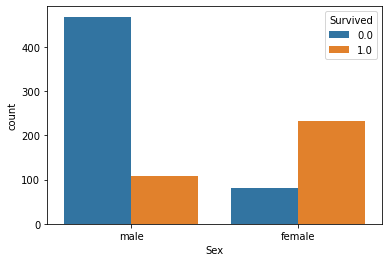

In [7]:
sns.countplot(x=df_data['Sex'], hue=df_data['Survived'])
display(df_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())

## 2.2 Analysis of Pclass

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


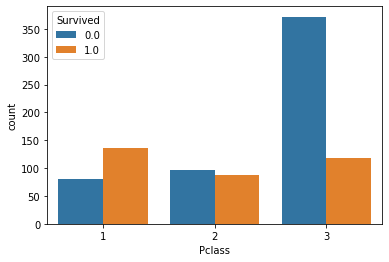

In [8]:
sns.countplot(x=df_data['Pclass'], hue=df_data['Survived'])
display(df_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

## 2.3 Analysis of Parch and SibSp

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000
7,9,NaN


,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


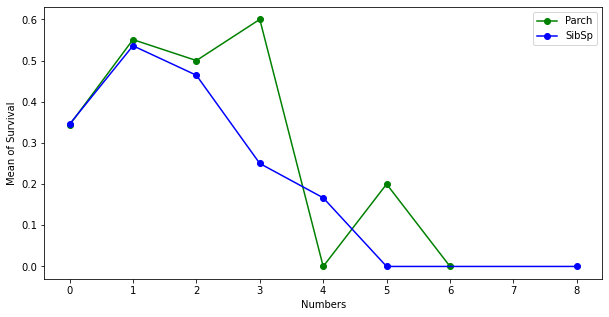

In [13]:
# Split two target data from df_data
df_parch = df_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean()
df_sibsp = df_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()
display(df_parch)
display(df_sibsp)

# Plot
fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.plot(df_parch['Parch'], df_parch['Survived'], '-og', label='Parch')
ax.plot(df_sibsp['SibSp'], df_sibsp['Survived'], '-ob', label='SibSp')
ax.set_xlabel('Numbers')
ax.set_ylabel('Mean of Survival')
ax.legend()
plt.show()

## 2.4 Analysis of Fare

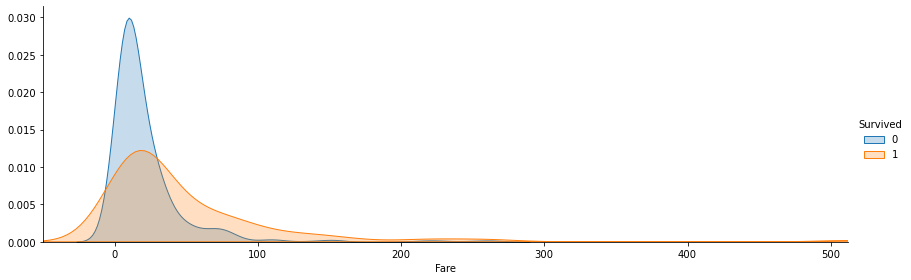

In [19]:
# Filling missing values
df_data['Fare'] = train_data['Fare'].fillna(df_data['Fare'].median())

fg = sns.FacetGrid(train_data, hue="Survived",aspect=3, height=4)
fg.map(sns.kdeplot, 'Fare', shade=True)
fg.set(xlim=(-50, train_data['Fare'].max()))
fg.add_legend()
plt.show()

### Observations
- 'Fare' has some outliers.
- Higher Fare has higher survival rate.
### Decisions
- We should be carefully exploiting 'Fare'.(e.g., bucketing to avoid overfitting)

## 2.5 Analysis of Embarked

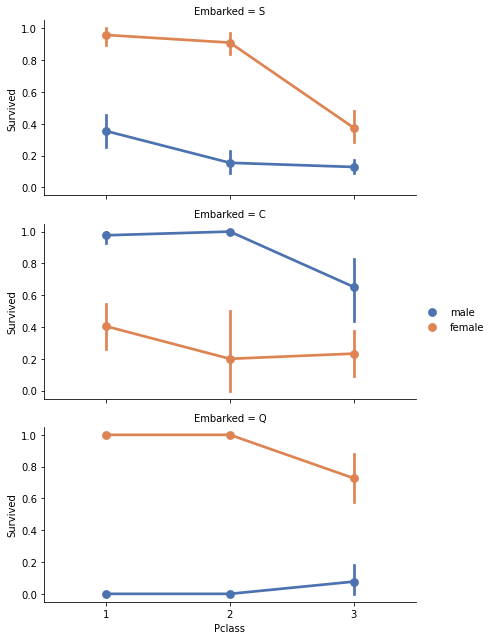

In [15]:
fg = sns.FacetGrid(df_data, row='Embarked', height=3, aspect=2)
fg.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', hue_order=None, order=[1, 2, 3])
fg.add_legend()
plt.show()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


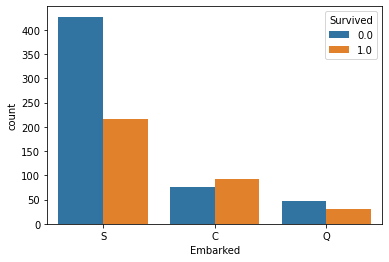

In [16]:
sns.countplot(x=df_data['Embarked'], hue=df_data['Survived'])
display(df_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

### Observations
- Males had higher survival rate than females at port C.
- Highest survival rate at C and lowest survival rate at S.
- Most passengers embarked at port S.
### Decisions
- The feature Embarked should be completed.
- We should consider Embarked in our training model.

# 3. Feature engineering and data cleaning

## 3.1 Encoding Sex feature

In [21]:
df_data['Sex#'] = df_data['Sex'].map({'male': 0, 'female': 1})
df_data.iloc[:, -1]

0       0
1       1
2       1
3       1
4       0
       ..
1304    0
1305    1
1306    0
1307    0
1308    0
Name: Sex#, Length: 1309, dtype: int64

## 3.2 Derive Fsize (family size) from Parch and SibSp

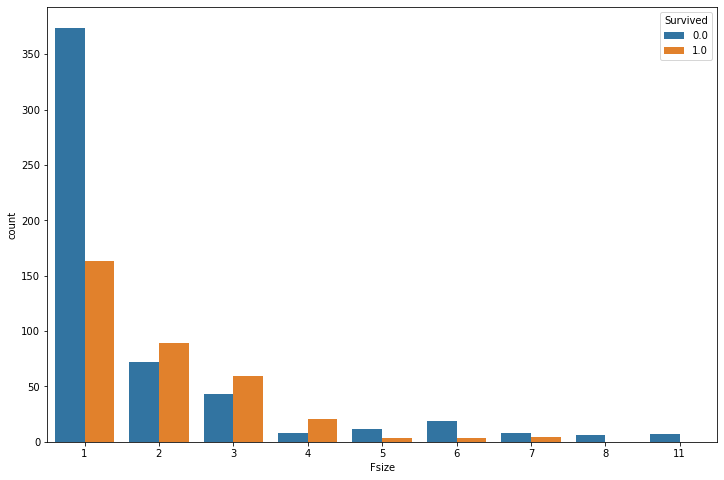

In [22]:
# Create new feature
df_data['Fsize'] = df_data['Parch'] + df_data['SibSp'] + 1 #Fsize stands for faily size = # of parents + # of siblins + self

# Plot
fg = plt.figure(figsize=(12, 8))
sns.countplot(x=df_data['Fsize'], hue=df_data['Survived'])
legend = plt.legend(title='Survived', loc='upper right')
plt.show()

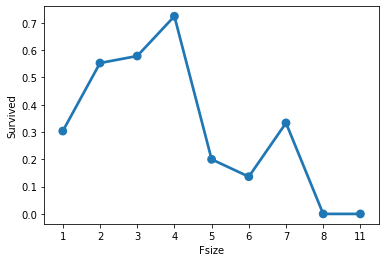

In [27]:
sns.pointplot(x='Fsize', y='Survived', data=df_data[['Fsize', 'Survived']].groupby(['Fsize'], as_index=False).mean())
plt.show()

## 3.3 Use IsAlone alternatively

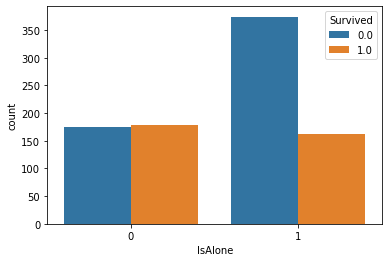

In [28]:
# Create new feature
df_data['IsAlone']  = 0
df_data.loc[df_data.Fsize == 1, 'IsAlone'] = 1

# Plot
sns.countplot(x=df_data['IsAlone'], hue=df_data['Survived'])
plt.show()

## 3.4 Bucketing/Binning Fare data

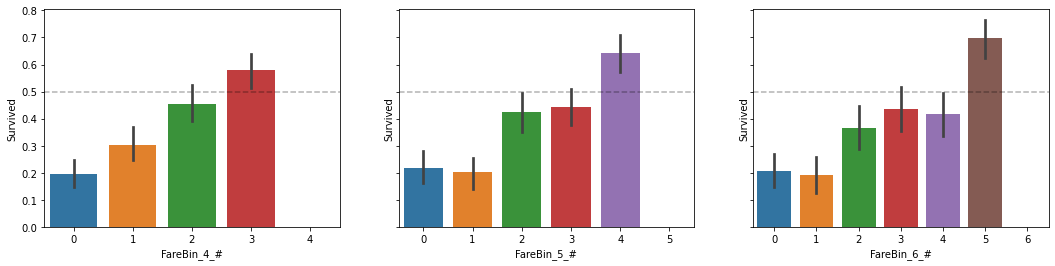

In [61]:
# Making bins
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)

# Mapping the bins
label_encoder = LabelEncoder()
df_data['FareBin_4_#'] = label_encoder.fit_transform(df_data['FareBin_4'])
df_data['FareBin_5_#'] = label_encoder.fit_transform(df_data['FareBin_5'])
df_data['FareBin_6_#'] = label_encoder.fit_transform(df_data['FareBin_6'])

# Plot
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)
fig.set_figwidth(18)
for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5, linestyle='dashed', c='black', alpha = .3)
g1 = sns.barplot(x='FareBin_4_#', y="Survived", data=df_data, ax=ax1)
g2 = sns.barplot(x='FareBin_5_#', y="Survived", data=df_data, ax=ax2)
g3 = sns.barplot(x='FareBin_6_#', y="Survived", data=df_data, ax=ax3)

In [76]:
# splits again beacuse we just engineered new feature
df_train = df_data[:num_train]
df_test = df_data[num_train:]

# Training set and labels
x_train = df_train.drop(labels=['Survived','PassengerId'], axis=1)
y_train = df_train['Survived']

# show columns
x_train.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Sex#', 'Fsize', 'IsAlone', 'FareBin_4',
       'FareBin_5', 'FareBin_6', 'FareBin_4_#', 'FareBin_5_#', 'FareBin_6_#'],
      dtype='object')

In [80]:
compare_features = ['Sex#','Pclass','FareBin_4_#','FareBin_5_#','FareBin_6_#']
estimator = RandomForestClassifier(n_estimators=250, min_samples_split=20)
selector = RFECV(estimator, cv=10, n_jobs=-1) # cv=10 means using 10-fold cross validation, n_jobs=-1 means using all processors
selector.fit(x_train[compare_features], y_train)

print('The mask of selected features: ', selector.support_) # The mask of selected features.
print('Feature rankings: ', selector.ranking_) # The feature ranking, such that ranking[i] corresponds to the ranking position of the i-th feature. 
print('CV scores: ', selector.grid_scores_*100) # The cross-validation scores such that grid_scores[i] corresponds to the CV score of the i-th subset of features.

The mask of selected features:  [ True  True  True  True  True]
Feature rankings:  [1 1 1 1 1]
CV scores:  [78.67290886 78.00374532 79.3545568  79.57677903 80.1423221 ]


In [110]:
score_b4,score_b5, score_b6 = [], [], []
seeds = 10

for i in range(seeds):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    estimator = RandomForestClassifier(random_state=i, n_estimators=250, min_samples_split=20)
    selector = RFECV(estimator=estimator, cv=cv, n_jobs=-1)
    selector.fit(x_train[compare_features], y_train)
    
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])

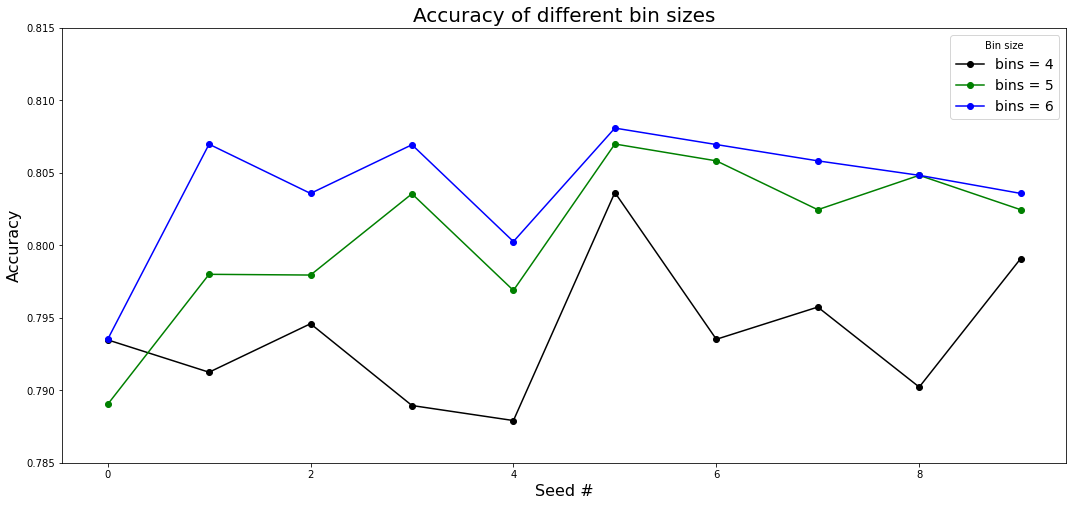

In [115]:
# to np.array
score_list = [score_b4, score_b5, score_b6]

for item in score_list:
    # print(type(item))
    item = np.array(item*100)
    # print(type(item), item.shape)

# plot
fig = plt.figure(figsize= (18,8))
ax = plt.gca()
ax.plot(range(seeds), score_b4,'-ok',label='bins = 4')
ax.plot(range(seeds), score_b5,'-og',label='bins = 5')
ax.plot(range(seeds), score_b6,'-ob',label='bins = 6')
ax.set_xlabel('Seed #', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.set_ylim(0.785, 0.815)
ax.set_title('Accuracy of different bin sizes', fontsize=20)
plt.legend(fontsize=14, loc='upper right', title='Bin size')
plt.show()

### From the plot, we can know:
- Bin size = 6 gets better accuracy at most of the time.
- Bin size = 5 works better in Seed 4 and Seed 5.
- Bin size = 4 only gets the best accuracy in Seed 0 and performs lowest accuracy at most of the time.
- The graph indicates that bin size = 6 is the best choice.

After plotting the data, we can change the aspect to the oob scores of models with different bin sizes.

In [116]:
b4, b5, b6 = ['Sex#', 'Pclass','FareBin_4_#'], ['Sex#','Pclass','FareBin_5_#'], ['Sex#','Pclass','FareBin_6_#']

# Train models and predict
b4_Model = RandomForestClassifier(
    random_state=2, 
    n_estimators=250, 
    min_samples_split=20, 
    oob_score=True)
b4_Model.fit(x_train[b4], y_train)

b5_Model = RandomForestClassifier(
    random_state=2, 
    n_estimators=250, 
    min_samples_split=20, 
    oob_score=True)
b5_Model.fit(x_train[b5], y_train)

b6_Model = RandomForestClassifier(
    random_state=2, 
    n_estimators=250, 
    min_samples_split=20, 
    oob_score=True)
b6_Model.fit(x_train[b6], y_train)

# Show oob scores
print('Bin size = 4, oob score :{}'.format(b4_Model.oob_score_))
print('Bin size = 5, oob score :{}'.format(b5_Model.oob_score_))
print('Bin size = 6, oob score :{}'.format(b6_Model.oob_score_))

Bin size = 4, oob score :0.7968574635241302
Bin size = 5, oob score :0.8103254769921436
Bin size = 6, oob score :0.8013468013468014


In [117]:
# Drop features we created in the process exclude FareBin_5_# which is what we need
df_data['FareBin'] = df_data['FareBin_5_#']
df_data = df_data.drop(['FareBin_4', 'FareBin_5', 'FareBin_6', 'FareBin_4_#', 'FareBin_5_#', 'FareBin_6_#'], axis=1)

In [120]:
df_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Sex#', 'Fsize',
       'IsAlone', 'FareBin'],
      dtype='object')

## 3.5 Family Name

## 3.6 Connected survival

## 3.7 Filling missing Embarked

## 3.8 Extract Title from Name

## 3.9 Age preprocessing

# 4. Build models

In [122]:
df_data[['PassengerId', 'Pclass', 'Sex#']] = df_data[['PassengerId', 'Pclass', 'Sex#']].astype('int32')
df_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex#,Fsize,IsAlone,FareBin
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,2,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,2,0,4
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,1,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,2,0,4
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1,1


## 4.1 Select features by correlation

In [129]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]
train_features = df_train.columns